In [32]:
import time
import json, os, shutil, sys
from tqdm import tqdm
import splitfolders
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
JSON_PATH = "metadata.json"
LIST_PATH = "data2/daytime_training_list.txt"
SOURCE_ROOT = "data2/snapshotserengeti-unzipped" 
OUTPUT_DIR = "organized_data"

In [ ]:
if os.path.exists(OUTPUT_DIR):
    print("restart")
else:
    TARGET_MAP = {
        'lionfemale': 'lion', 'lionmale': 'lion', 'lioncub': 'lion',
        'zebra': 'zebra', 'giraffe': 'giraffe', 'elephant': 'elephant',
        'cheetah': 'cheetah', 'leopard': 'leopard', 'hyenaspotted': 'hyena',
        'hyenastriped': 'hyena', 'hyenabrown': 'hyena',
        'impala': 'impala', 'gazellethomsons': 'gazelle', 'gazellegrants': 'gazelle',
        'wildebeest': 'wildebeest', 'hartebeest': 'hartebeest', 'kudu': 'kudu',
        'warthog': 'warthog', 'buffalo': 'buffalo', 'baboon': 'baboon',
        'ostrich': 'ostrich', 'human': 'human', 'empty': 'empty', 'caracal': 'caracal'
    }

    with open(JSON_PATH, 'r') as f:
        meta = json.load(f)

    cat_id_map = {c['id']: c['name'] for c in meta['categories']}
    path_map = {ann['image_id']: cat_id_map.get(ann['category_id']) for ann in meta['annotations']}

    with open(LIST_PATH, 'r') as f:
        files = [l.strip() for l in f if l.strip()]

    for path in tqdm(files):
        label = TARGET_MAP.get(path_map.get(path.rsplit('.', 1)[0]))
        if label:
            src = os.path.join(SOURCE_ROOT, path)
            if os.path.exists(src):
                dst = os.path.join(OUTPUT_DIR, label)
                os.makedirs(dst, exist_ok=True)
                shutil.copy(src, os.path.join(dst, os.path.basename(path)))

restart


In [3]:
if os.path.exists("split_data"):
    print("restart")
else:
    # ratio=(train, validation, test)
    splitfolders.ratio("organized_data", output="split_data", 
                       seed=42, ratio=(.8, .1, .1))
    print("Split complete!")

restart


In [ ]:

print("GPU found:" , tf.config.list_physical_devices('GPU'))

GPU found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [25]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    'split_data/train',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'split_data/val',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    shuffle=False
)

class_names = train_ds.class_names
train_ds = train_ds.apply(tf.data.experimental.ignore_errors()).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.apply(tf.data.experimental.ignore_errors()).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 14980 files belonging to 16 classes.
Found 1867 files belonging to 16 classes.


In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as vgg_pre
vgg_train = train_ds.map(lambda x, y: (vgg_pre(x), y))
vgg_val = val_ds.map(lambda x, y: (vgg_pre(x), y))

base_vgg = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_vgg.trainable = False
model_vgg = models.Sequential([base_vgg, layers.GlobalAveragePooling2D(), layers.Dense(256, activation='relu'), layers.Dropout(0.5), layers.Dense(len(class_names), activation='softmax')])
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg.fit(vgg_train, validation_data=vgg_val, epochs=20, callbacks=[callbacks.CSVLogger('vgg19_training_log.csv'), callbacks.ModelCheckpoint('vgg19_best.h5', save_best_only=True)])

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as res_pre
res_train = train_ds.map(lambda x, y: (res_pre(x), y))
res_val = val_ds.map(lambda x, y: (res_pre(x), y))

base_res = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_res.trainable = False
model_res = models.Sequential([base_res, layers.GlobalAveragePooling2D(), layers.Dense(256, activation='relu'), layers.Dropout(0.5), layers.Dense(len(class_names), activation='softmax')])
model_res.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_res.fit(res_train, validation_data=res_val, epochs=20, callbacks=[callbacks.CSVLogger('resnet50_baseline_log.csv'), callbacks.ModelCheckpoint('resnet50_baseline.h5', save_best_only=True)])

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mob_pre
mob_train = train_ds.map(lambda x, y: (mob_pre(x), y))
mob_val = val_ds.map(lambda x, y: (mob_pre(x), y))

base_mob = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_mob.trainable = False
model_mob = models.Sequential([base_mob, layers.GlobalAveragePooling2D(), layers.Dense(256, activation='relu'), layers.Dropout(0.5), layers.Dense(len(class_names), activation='softmax')])
model_mob.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_mob.fit(mob_train, validation_data=mob_val, epochs=20, callbacks=[callbacks.CSVLogger('mobilenet_baseline_log.csv'), callbacks.ModelCheckpoint('mobilenet_baseline.h5', save_best_only=True)])

Epoch 1/20
467/467 [==============================] - 72s 151ms/step - loss: 1.7925 - accuracy: 0.4812 - val_loss: 1.1107 - val_accuracy: 0.6711
Epoch 2/20
467/467 [==============================] - 86s 182ms/step - loss: 1.2269 - accuracy: 0.6148 - val_loss: 0.9828 - val_accuracy: 0.7001
Epoch 3/20
467/467 [==============================] - 105s 223ms/step - loss: 1.0616 - accuracy: 0.6651 - val_loss: 0.9130 - val_accuracy: 0.7279
Epoch 4/20
467/467 [==============================] - 118s 250ms/step - loss: 0.9786 - accuracy: 0.6873 - val_loss: 0.8732 - val_accuracy: 0.7258
Epoch 5/20
467/467 [==============================] - 125s 266ms/step - loss: 0.9150 - accuracy: 0.7105 - val_loss: 0.8414 - val_accuracy: 0.7488
Epoch 6/20
467/467 [==============================] - 134s 284ms/step - loss: 0.8654 - accuracy: 0.7235 - val_loss: 0.8231 - val_accuracy: 0.7461
Epoch 7/20
467/467 [==============================] - 138s 293ms/step - loss: 0.8206 - accuracy: 0.7342 - val_loss: 0.8023 - v

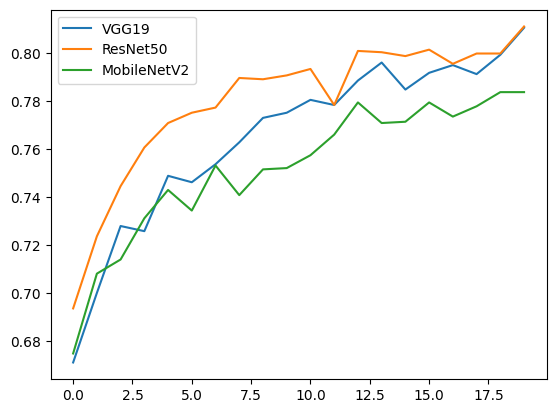

59/59 [==============================] - 5s 86ms/step


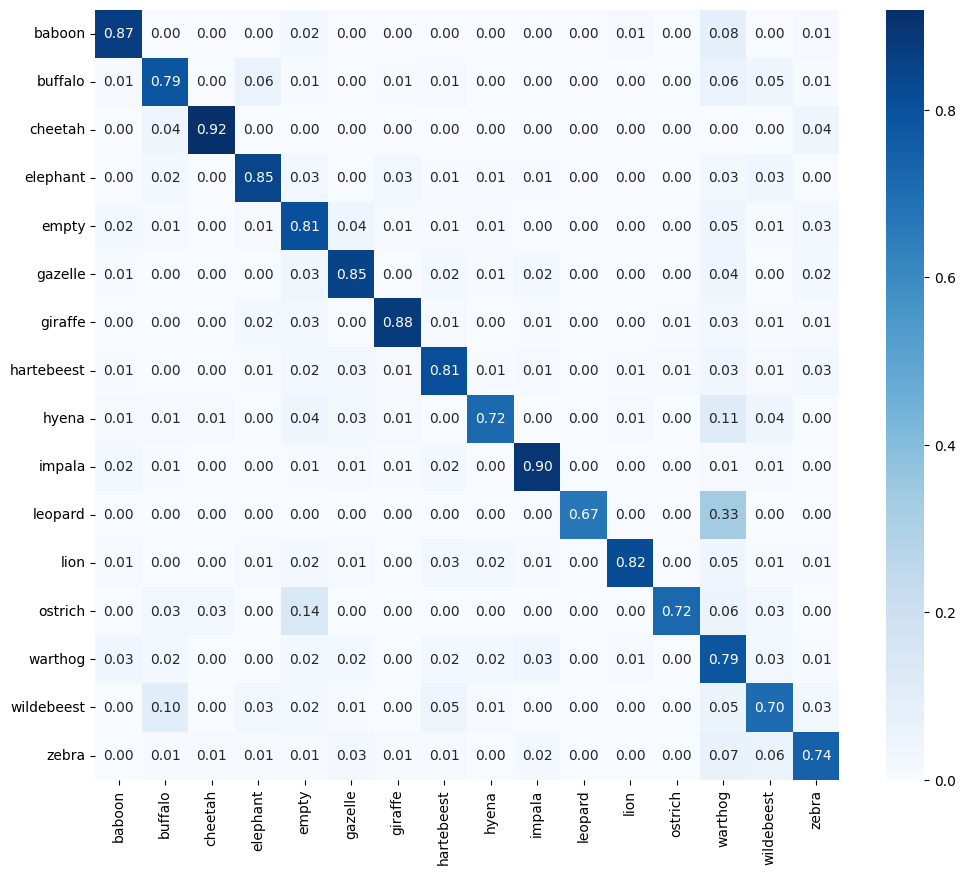

              precision    recall  f1-score   support

      baboon       0.80      0.87      0.83        83
     buffalo       0.80      0.79      0.79       150
     cheetah       0.85      0.92      0.88        25
    elephant       0.85      0.85      0.85       150
       empty       0.76      0.81      0.78       150
     gazelle       0.84      0.85      0.85       150
     giraffe       0.91      0.88      0.89       150
  hartebeest       0.81      0.81      0.81       150
       hyena       0.82      0.72      0.76        74
      impala       0.89      0.90      0.89       149
     leopard       1.00      0.67      0.80         3
        lion       0.96      0.82      0.88       150
     ostrich       0.90      0.72      0.80        36
     warthog       0.59      0.79      0.68       149
  wildebeest       0.74      0.70      0.72       149
       zebra       0.83      0.74      0.79       149

    accuracy                           0.81      1867
   macro avg       0.83   

In [30]:
vgg_l, res_l, mob_l = pd.read_csv('vgg19_training_log.csv'), pd.read_csv('resnet50_baseline_log.csv'), pd.read_csv('mobilenet_baseline_log.csv')
plt.plot(vgg_l['val_accuracy'], label='VGG19'); plt.plot(res_l['val_accuracy'], label='ResNet50'); plt.plot(mob_l['val_accuracy'], label='MobileNetV2')
plt.legend(); plt.savefig('accuracy_comparison.png'); plt.show()


y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(model_res.predict(res_val), axis=1)

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12,10))
sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.savefig('confusion_matrix.png'); plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

59/59 [==============================] - 5s 85ms/step
VGG19 Classification Report:
              precision    recall  f1-score   support

      baboon       0.87      0.80      0.83        83
     buffalo       0.80      0.85      0.83       150
     cheetah       0.79      0.76      0.78        25
    elephant       0.86      0.83      0.84       150
       empty       0.67      0.89      0.76       150
     gazelle       0.80      0.85      0.82       150
     giraffe       0.88      0.87      0.88       150
  hartebeest       0.89      0.83      0.86       150
       hyena       0.72      0.77      0.75        74
      impala       0.90      0.84      0.87       149
     leopard       1.00      0.67      0.80         3
        lion       0.89      0.89      0.89       150
     ostrich       0.93      0.72      0.81        36
     warthog       0.76      0.70      0.73       149
  wildebeest       0.73      0.69      0.71       149
       zebra       0.79      0.74      0.76       14

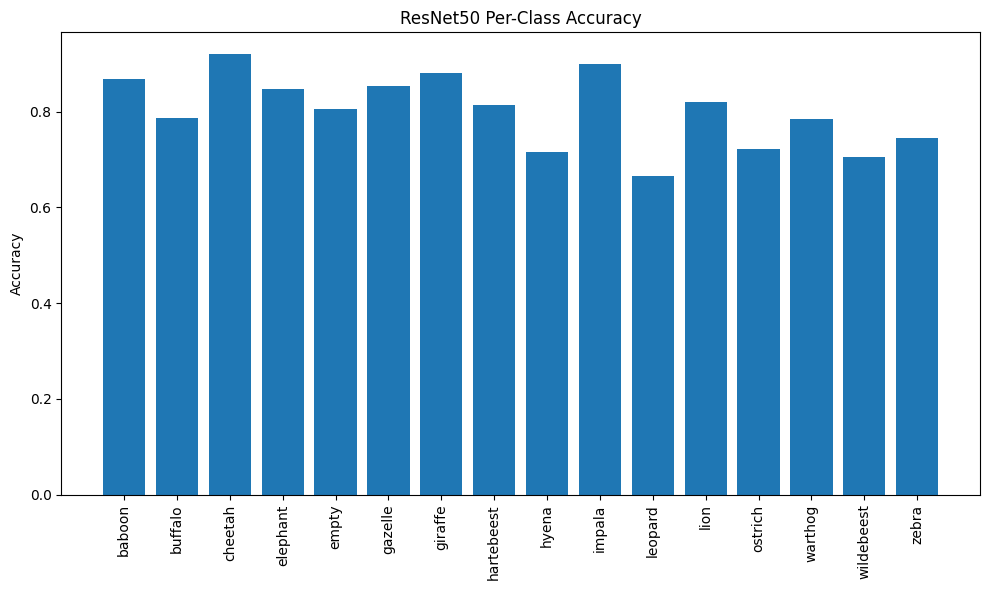

In [33]:
from sklearn.metrics import classification_report

y_pred_vgg = np.argmax(model_vgg.predict(vgg_val), axis=1)
y_pred_res = np.argmax(model_res.predict(res_val), axis=1)
y_pred_mob = np.argmax(model_mob.predict(mob_val), axis=1)

print("VGG19 Classification Report:")
print(classification_report(y_true, y_pred_vgg, target_names=class_names))

print("ResNet50 Classification Report:")
print(classification_report(y_true, y_pred_res, target_names=class_names))

print("MobileNetV2 Classification Report:")
print(classification_report(y_true, y_pred_mob, target_names=class_names))

def benchmark_inference(model, preprocessed_ds, model_name):
    times = []
    for batch, _ in preprocessed_ds.take(10):
        start = time.time()
        model.predict(batch)
        end = time.time()
        times.append((end - start) / batch.shape[0])
    avg_time = np.mean(times) * 1000  # ms per image
    print(f"{model_name}: {avg_time:.2f} ms per image")
    return avg_time

vgg_time = benchmark_inference(model_vgg, vgg_val, "VGG19")
res_time = benchmark_inference(model_res, res_val, "ResNet50")
mob_time = benchmark_inference(model_mob, mob_val, "MobileNetV2")

# 3. Per-class accuracy visualization
per_class_acc = {}
for i, class_name in enumerate(class_names):
    idx = np.where(y_true == i)[0]
    correct = np.sum(y_pred_res[idx] == i)
    per_class_acc[class_name] = correct / len(idx)

plt.figure(figsize=(10,6))
plt.bar(per_class_acc.keys(), per_class_acc.values())
plt.xticks(rotation=90)
plt.ylabel("Accuracy")
plt.title("ResNet50 Per-Class Accuracy")
plt.tight_layout()
plt.savefig("per_class_accuracy.png")
plt.show()